In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [4]:
tickers = ["AAPL","MSFT","AMZN"]
data = yf.download(tickers, start = "2019-01-01", end = "2024-01-01")["Adj Close"]
data.head()

[*********************100%%**********************]  3 of 3 completed


,AAPL,AMZN,MSFT
Date,,,
2019-01-02,37.750084,76.956497,95.501312
2019-01-03,33.989899,75.014000,91.988037
2019-01-04,35.440907,78.769501,96.266312
2019-01-07,35.362015,81.475502,96.389084
2019-01-08,36.036129,82.829002,97.087990


In [6]:
#daily returns
returns = data.pct_change().dropna()
returns.head()

,AAPL,AMZN,MSFT
Date,,,
2019-01-03,-0.099607,-0.025241,-0.036788
2019-01-04,0.042689,0.050064,0.046509
2019-01-07,-0.002226,0.034353,0.001275
2019-01-08,0.019063,0.016612,0.007251
2019-01-09,0.016982,0.001714,0.014299


In [7]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [11]:
#Defining Port Opt function
def portfolio_volatility(weights,cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights)))

def portfolio_return(weights,mean_returns):
    return np.dot(weights,mean_returns)

def min_risk(weights,cov_matrix):
    return portfolio_volatility(weights,cov_matrix)

constraints = ({'type':'eq','fun':lambda x: np.sum(x) -1})
bounds = tuple((0,1) for _ in range(len(tickers)))

In [12]:
# Initial guess for weights
init_guess = [1/len(tickers)] * len(tickers)

# Minimize portfolio risk
optimized_result = minimize(min_risk, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights for minimum risk portfolio
min_risk_weights = optimized_result.x
min_risk_volatility = portfolio_volatility(min_risk_weights, cov_matrix)
min_risk_return = portfolio_return(min_risk_weights, mean_returns)

In [25]:
# Generate portfolios along the efficient frontier
def efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    results = {'returns': [], 'volatility': [], 'weights': []}
    
    for _ in range(num_portfolios):
        # Random weights for portfolio
        weights = np.random.normal(0,1, len(mean_returns))
        weights = np.abs(weights)
        weights /= np.sum(weights)
        returns = portfolio_return(weights, mean_returns)
        volatility = portfolio_volatility(weights, cov_matrix)
        
        # Save results
        results['returns'].append(returns)
        results['volatility'].append(volatility)
        results['weights'].append(weights)
    
    return results

ef_results = efficient_frontier(mean_returns, cov_matrix)

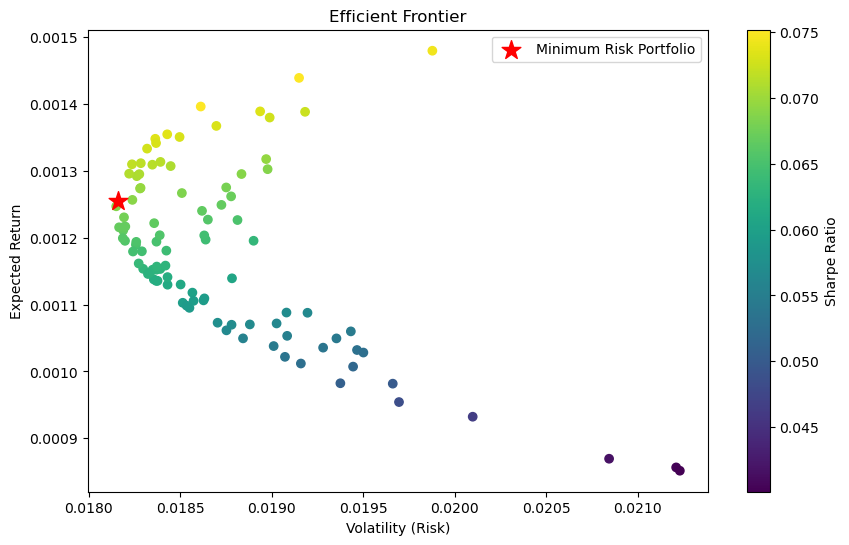

In [26]:
# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(ef_results['volatility'], ef_results['returns'], c=(np.array(ef_results['returns']) / np.array(ef_results['volatility'])), marker='o')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(min_risk_volatility, min_risk_return, color='red', marker='*', s=200, label='Minimum Risk Portfolio')
plt.title('Efficient Frontier')
plt.legend()
plt.show()